# Trademark ducky dataset Phase Retrieval

> Georgios Varnavides | Dec 21 2025  
>
> Sample: graphene substrate ducky  
> Sampling conditions: 4 Ang step-sizes  
> Imaging conditions: 20 mrad, 500 A  

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import quantem as em
import numpy as np

/Users/gvarnavides/Documents/git-repos/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = em.core.io.load("../data/ducky_20mrad_500A-df_4A-step.zip")
dataset

Dataset(shape=(41, 41, 200, 200), dtype=float32, name='4D-STEM dataset')
  sampling: [4.         4.         1.04392901 1.04392901]
  units: ['A', 'A', 'mrad', 'mrad']
  signal units: 'arb. units'

In [4]:
energy = 80e3
semiangle_cutoff = 20
defocus = 500
rotation_angle = np.deg2rad(-15)

In [5]:
def add_poisson_noise(
    dataset,
    electrons_per_area,
):
    if electrons_per_area == np.inf:
        return dataset
    electrons_per_probe = electrons_per_area * dataset.sampling[:2].prod()
    
    dataset_noisy = dataset.copy()
    dataset_noisy.array = np.random.poisson(dataset.array * electrons_per_probe)
    return dataset_noisy

In [6]:
np.random.seed(2025)
noisy_dataset = add_poisson_noise(
    dataset,
    1e5
)

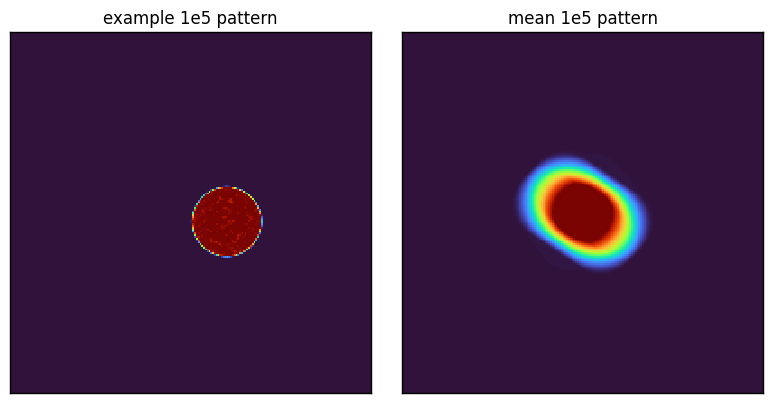

In [7]:
# notice the descan!
em.visualization.show_2d(
    [
        noisy_dataset[0,0].array,
        noisy_dataset.mean((0,1)),
    ],
    title=[
        "example 1e5 pattern","mean 1e5 pattern"
    ],
    power=0.5,
    cmap='turbo'
);

In [8]:
direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    noisy_dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=rotation_angle,
    aberration_coefs={"defocus":defocus},
    # device='gpu',
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.84it/s]


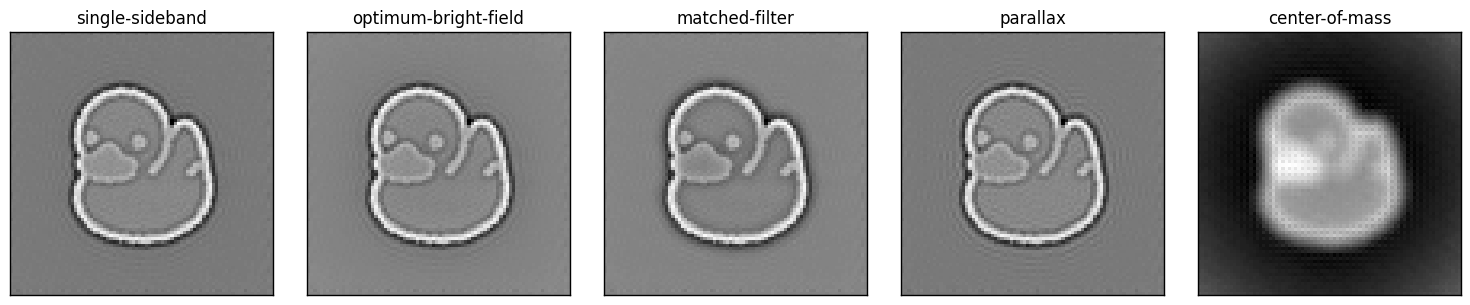

In [9]:
kwargs = {
    "title":["single-sideband","optimum-bright-field","matched-filter","parallax","center-of-mass"],
    "norm":"minmax",
    "axsize":(3,3),
}

recons = direct_ptycho._reconstruct_all_permutations(
    upsampling_factor=2,
)

em.visualization.show_2d(
    recons,
    **kwargs
);

In [10]:
# Optimize defocus with optuna
direct_ptycho = direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "C12":em.diffractive_imaging.direct_ptychography.OptimizationParameter(0,100),
        "phi12":em.diffractive_imaging.direct_ptychography.OptimizationParameter(-np.pi/2,np.pi/2)
    },
    rotation_angle=em.diffractive_imaging.direct_ptychography.OptimizationParameter(-0.5,0,0),
    n_trials=250,
    deconvolution_kernel='parallax',
)

Best trial: 183. Best value: 3.56553e-09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:22<00:00, 11.14it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': -500.0},
  initial_rotation_angle=np.float64(-0.2617993877991494),
  optimized_aberrations={'C12': 1.8162295891101499, 'phi12': -0.11354283254229616},
  optimized_rotation_angle=-0.26356731789627974,
)


Reconstructing with:

 HyperparameterState(
  current_aberrations={'C10': -500.0, 'C12': 1.8162295891101499, 'phi12': -0.11354283254229616},
  current_rotation_angle=-0.26356731789627974,
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1153/1153 [00:00<00:00, 13439.77it/s]


(<Figure size 400x400 with 1 Axes>, <Axes: >)

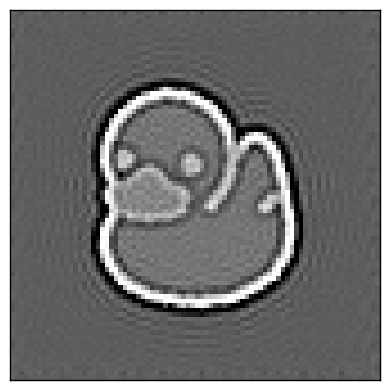

In [12]:
em.visualization.show_2d(
    direct_ptycho.reconstruct(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
    ).obj
)

In [13]:
# reference fit from scratch (note the aberration_coeffs = {} and rotation_angle=0.0 arguments overriding init values)
direct_ptycho.fit_hyperparameters(
    alignment_method='reference',
    bin_factors=(3,2,1,1,1),

    # reset aberrations and rotation to prove it can find it from scratch.
    aberration_coefs = {'C10':0.0,'C12':0.0,'phi12':0.0},
    rotation_angle= 0.0,
);

Aligning (reference): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.15it/s]

Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': -500.0},
  initial_rotation_angle=np.float64(-0.2617993877991494),
  optimized_aberrations={'C10': -529.3759765625, 'C12': 0.6090437769889832, 'phi12': -0.03882812336087227},
  optimized_rotation_angle=-0.2626831531524658,
)


Reconstructing with:

 HyperparameterState(
  current_aberrations={'C10': -529.3759765625, 'C12': 0.6090437769889832, 'phi12': -0.03882812336087227},
  current_rotation_angle=-0.2626831531524658,
)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1153/1153 [00:00<00:00, 14873.14it/s]


(<Figure size 400x400 with 1 Axes>, <Axes: >)

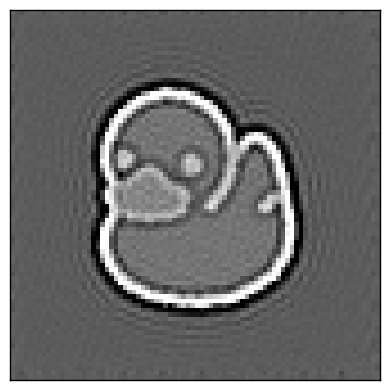

In [15]:
em.visualization.show_2d(
    direct_ptycho.reconstruct(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
    ).obj
)